In [273]:
import pandas as pd
from PIL import Image
import numpy as np
import os
import random
import matplotlib.pyplot as plt

In [322]:
unregistered_csv='GCA020TIB_unregistered_classified.csv'
registered_csv='GCA020TIB_registered_classified.csv'

unregistered_df=pd.read_csv(unregistered_csv)
registered_df=pd.read_csv(registered_csv)


In [323]:
#Make a new dataframe and get the gained, lost and changed instances in there
class_labels = [col for col in registered_df.columns if col.startswith("final_")]

analysis_df = pd.DataFrame({
    'Instance': unregistered_df['Instances'],  # Assuming 'Instances' is the column name in your CSV
    'Gain': False,
    'Loss': False,
    'Change': False,
    'Before Classification': '',
    'After Classification': ''
})

# Iterate through each row to determine gain, loss, and change
for index, (reg_row, unreg_row) in enumerate(zip(registered_df.iterrows(), unregistered_df.iterrows())):
    reg_classes = [label for label in class_labels if reg_row[1][label]]
    unreg_classes = [label for label in class_labels if unreg_row[1][label]]

    # Determine before and after classification
    before_classification = unreg_classes[0] if unreg_classes else 'Undefined'
    after_classification = reg_classes[0] if reg_classes else 'Undefined'
    
    analysis_df.at[index, 'Before Classification'] = before_classification
    analysis_df.at[index, 'After Classification'] = after_classification

    # Determine gain, loss, and change
    if unreg_row[1]['Undefined'] and reg_classes:
        analysis_df.at[index, 'Gain'] = True
    elif reg_row[1]['Undefined'] and unreg_classes:
        analysis_df.at[index, 'Loss'] = True
    elif unreg_classes and reg_classes and before_classification != after_classification:
        analysis_df.at[index, 'Change'] = True


In [324]:
analysis_df.tail()

,Instance,Gain,Loss,Change,Before Classification,After Classification
15405,15406,False,False,False,Undefined,Undefined
15406,15407,False,False,True,final_Enterocytes,final_Progenitor
15407,15408,False,False,False,Undefined,Undefined
15408,15409,False,False,False,Undefined,Undefined
15409,15410,False,False,False,Undefined,Undefined


In [325]:
#Gains for Enteroendocrine
indexes_gained=analysis_df[(analysis_df['Before Classification']=='Undefined') & (analysis_df['After Classification']=='final_Progenitor')].index

#Losses for Enteroendocrine
indexes_lost=analysis_df[(analysis_df['Before Classification']=='final_Progenitor') & (analysis_df['After Classification']=='Undefined')].index

#Changes for Enteroendocrine
indexes_changed=analysis_df[(analysis_df['Before Classification']=='final_Progenitor') & (analysis_df['After Classification']!='final_Progenitor') & (analysis_df['After Classification']!='Undefined')].index


In [326]:
len(indexes_gained),len(indexes_lost),len(indexes_changed)

(785, 26, 74)

In [327]:
#Radomly select 1 indec from indexes_gained
random_index=random.choice(indexes_gained)

In [328]:
#Get the mask image for that tissue
tissue_name='GCA007ACB'

mask_path=f'/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/{tissue_name}/mask.tif'
mask=np.array(Image.open(mask_path))

marker1='/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA020TIB_TISSUE01/AF_Removed/ROUND_16_CY3_GCA020TIB_TISSUE01_Sox9_normalized_corrected.tif'
marker1=np.array(Image.open(marker1))

marker2='/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/GCA020TIB_TISSUE01/Unregistered/AF_Removed/ROUND_16_CY3_GCA020TIB_TISSUE01_Sox9_normalized_corrected.tif'
marker2=np.array(Image.open(marker2))

/home-local/rudravg/conda_envs/cell_classification/lib/python3.12/site-packages/PIL/Image.py:3218: DecompressionBombWarning: Image size (92801457 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..14.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..8.0].


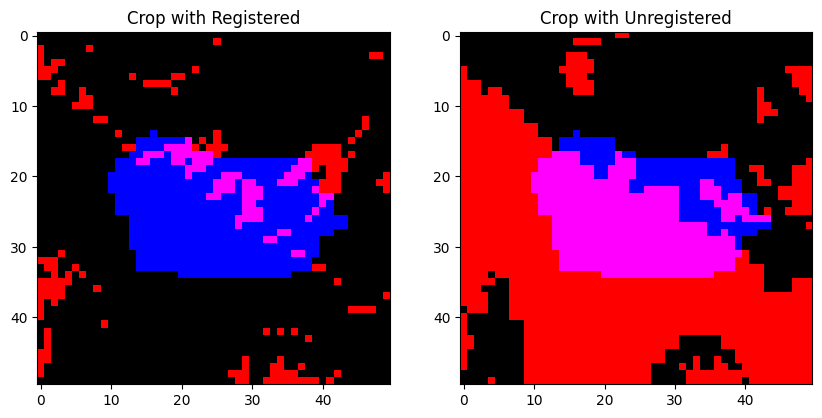

In [329]:
instance_mask = mask == random_index

# Get the centroid of the instance
centroid = np.mean(np.argwhere(instance_mask), axis=0)

# Now make a new image by cropping the mask 200 pixels square with center as centroid
crop_size = 50
crop = instance_mask[int(centroid[0]-crop_size/2):int(centroid[0]+crop_size/2), int(centroid[1]-crop_size/2):int(centroid[1]+crop_size/2)]

# Crop the marker1 image as well
crop_marker1 = marker1[int(centroid[0]-crop_size/2):int(centroid[0]+crop_size/2), int(centroid[1]-crop_size/2):int(centroid[1]+crop_size/2)]

# Crop the marker2 image as well
crop_marker2 = marker2[int(centroid[0]-crop_size/2):int(centroid[0]+crop_size/2), int(centroid[1]-crop_size/2):int(centroid[1]+crop_size/2)]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Overlay the crop with crop_marker1 and display in the first subplot
crop_overlay1 = np.zeros((crop.shape[0], crop.shape[1], 3))
crop_overlay1[:,:,2] = crop
crop_overlay1[:,:,0] = crop_marker1
axs[0].imshow(crop_overlay1)
axs[0].set_title('Crop with Registered')

# Overlay the crop with crop_marker2 and display in the second subplot
crop_overlay2 = np.zeros((crop.shape[0], crop.shape[1], 3))
crop_overlay2[:,:,2] = crop
crop_overlay2[:,:,0] = crop_marker2
axs[1].imshow(crop_overlay2)
axs[1].set_title('Crop with Unregistered')

plt.show()

In [330]:
#Visualize the changed instances along with overlap with all the markers
marker_list = ['CD11B','CD20','CD3D','CD45','CD4','CD68','CD8','CGA','LYSOZYME','NAKATPASE','PANCK','SMA','SOX9','VIMENTIN','OLFM4','MUC2']

registered_marker_path=f'/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/{tissue_name}/AF_Removed/'
unregistered_marker_path=f'/fs5/p_masi/rudravg/MxIF_Vxm_Registered_V2/{tissue_name}/Unregistered/AF_Removed/'

#Find all file names in registered marker_path which have the marker name from the marker list, compare it after capitalizing the file paths
registered_marker_files = [file for file in os.listdir(registered_marker_path) if any(marker.upper() in file.upper() for marker in marker_list)]

#Sort it based on the marker list
registered_marker_files = sorted(registered_marker_files, key=lambda x: [marker.upper() in x.upper() for marker in marker_list], reverse=True)

In [331]:
registered_marker_files

['ROUND_09_CY2_GCA007ACB_CD11B_normalized_corrected.tif',
 'ROUND_03_CY5_GCA007ACB_CD20_normalized_corrected.tif',
 'ROUND_09_CY3_GCA007ACB_CD3D_normalized_corrected.tif',
 'ROUND_11_CY3_GCA007ACB_CD3D_normalized_corrected.tif',
 'ROUND_01_CY5_GCA007ACB_CD45_normalized_corrected.tif',
 'ROUND_07_CY5_GCA007ACB_CD4_normalized_corrected.tif',
 'ROUND_07_CY3_GCA007ACB_CD68_normalized_corrected.tif',
 'ROUND_13_CY5_GCA007ACB_CD8-bad_normalized_corrected.tif',
 'ROUND_11_CY5_GCA007ACB_CD8_normalized_corrected.tif',
 'ROUND_05_CY3_GCA007ACB_CGA_normalized_corrected.tif',
 'ROUND_17_CY2_GCA007ACB_LYSOZYME_normalized_corrected.tif',
 'ROUND_09_CY5_GCA007ACB_NAKATPASE_normalized_corrected.tif',
 'ROUND_13_CY2_GCA007ACB_PANCK-bad_normalized_corrected.tif',
 'ROUND_11_CY2_GCA007ACB_PANCK_normalized_corrected.tif',
 'ROUND_15_CY3_GCA007ACB_SMA_normalized_corrected.tif',
 'ROUND_19_CY3_GCA007ACB_SOX9_normalized_corrected.tif',
 'ROUND_17_CY3_GCA007ACB_SOX9_normalized_corrected.tif',
 'ROUND_15_CY2_G

In [332]:
CD11B_registered=os.path.join(registered_marker_path,registered_marker_files[0])
CD11B_registered=np.array(Image.open(CD11B_registered))

CD11B_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[0])
CD11B_unregistered=np.array(Image.open(CD11B_unregistered))

CD20_registered=os.path.join(registered_marker_path,registered_marker_files[1]) 
CD20_registered=np.array(Image.open(CD20_registered))

CD20_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[1])
CD20_unregistered=np.array(Image.open(CD20_unregistered))

CD3D_registered=os.path.join(registered_marker_path,registered_marker_files[2])
CD3D_registered=np.array(Image.open(CD3D_registered))

CD3D_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[2])
CD3D_unregistered=np.array(Image.open(CD3D_unregistered))

CD45_registered=os.path.join(registered_marker_path,registered_marker_files[3])
CD45_registered=np.array(Image.open(CD45_registered))

CD45_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[3])
CD45_unregistered=np.array(Image.open(CD45_unregistered))

CD4_registered=os.path.join(registered_marker_path,registered_marker_files[4])
CD4_registered=np.array(Image.open(CD4_registered))

CD4_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[4])
CD4_unregistered=np.array(Image.open(CD4_unregistered))

CD68_registered=os.path.join(registered_marker_path,registered_marker_files[5])
CD68_registered=np.array(Image.open(CD68_registered))

CD68_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[5])
CD68_unregistered=np.array(Image.open(CD68_unregistered))

CD8_registered=os.path.join(registered_marker_path,registered_marker_files[6])
CD8_registered=np.array(Image.open(CD8_registered))

CD8_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[6])
CD8_unregistered=np.array(Image.open(CD8_unregistered))

CGA_registered=os.path.join(registered_marker_path,registered_marker_files[7])
CGA_registered=np.array(Image.open(CGA_registered))

CGA_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[7])
CGA_unregistered=np.array(Image.open(CGA_unregistered))

LYSOZYME_registered=os.path.join(registered_marker_path,registered_marker_files[8])
LYSOZYME_registered=np.array(Image.open(LYSOZYME_registered))

LYSOZYME_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[8])
LYSOZYME_unregistered=np.array(Image.open(LYSOZYME_unregistered))

NAKATPASE_registered=os.path.join(registered_marker_path,registered_marker_files[9])
NAKATPASE_registered=np.array(Image.open(NAKATPASE_registered))

NAKATPASE_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[9])
NAKATPASE_unregistered=np.array(Image.open(NAKATPASE_unregistered))

PANCK_registered=os.path.join(registered_marker_path,registered_marker_files[10])
PANCK_registered=np.array(Image.open(PANCK_registered))

PANCK_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[10])
PANCK_unregistered=np.array(Image.open(PANCK_unregistered))

SMA_registered=os.path.join(registered_marker_path,registered_marker_files[11])
SMA_registered=np.array(Image.open(SMA_registered))

SMA_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[11])
SMA_unregistered=np.array(Image.open(SMA_unregistered))

SOX9_registered=os.path.join(registered_marker_path,registered_marker_files[12])
SOX9_registered=np.array(Image.open(SOX9_registered))

SOX9_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[12])
SOX9_unregistered=np.array(Image.open(SOX9_unregistered))

VIMENTIN_registered=os.path.join(registered_marker_path,registered_marker_files[13])
VIMENTIN_registered=np.array(Image.open(VIMENTIN_registered))

VIMENTIN_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[13])
VIMENTIN_unregistered=np.array(Image.open(VIMENTIN_unregistered))

OLFM4_registered=os.path.join(registered_marker_path,registered_marker_files[14])
OLFM4_registered=np.array(Image.open(OLFM4_registered))

OLFM4_unregistered=os.path.join(unregistered_marker_path,registered_marker_files[14])
OLFM4_unregistered=np.array(Image.open(OLFM4_unregistered))                            
                        


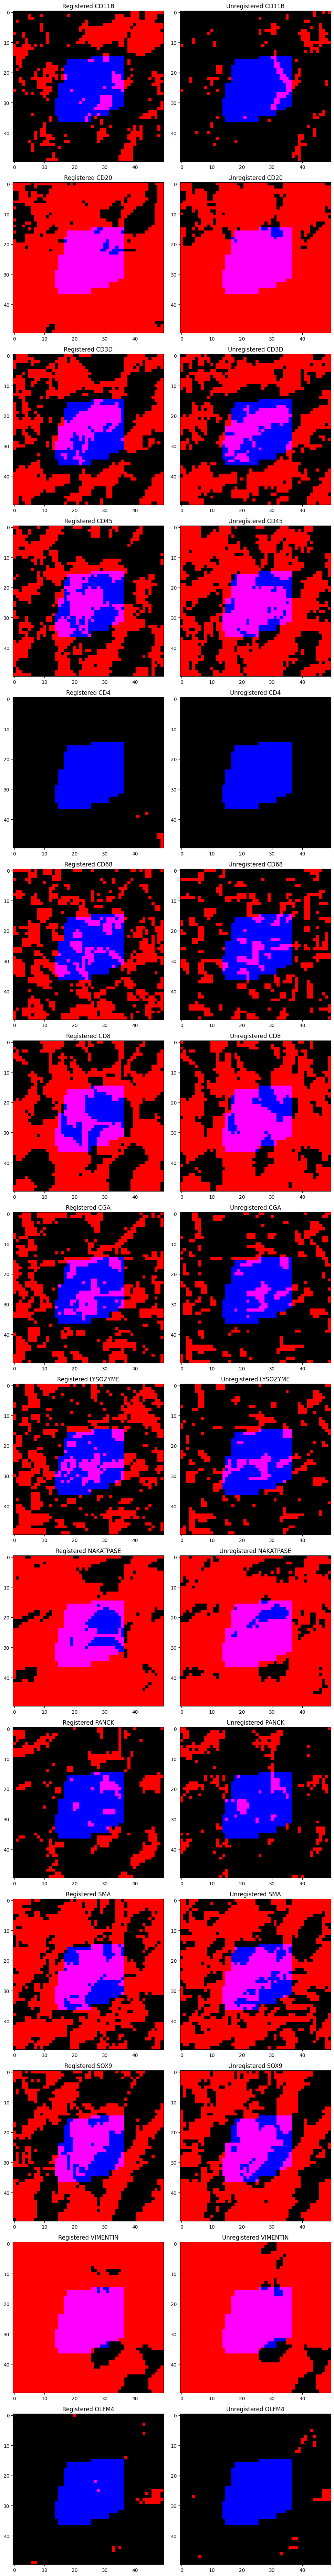

In [333]:
def crop_and_overlay(mask, registered, unregistered, centroid, crop_size=50):
    # Calculate crop boundaries
    start_row = int(centroid[0] - crop_size / 2)
    end_row = int(centroid[0] + crop_size / 2)
    start_col = int(centroid[1] - crop_size / 2)
    end_col = int(centroid[1] + crop_size / 2)
    
    # Crop images
    crop_mask = mask[start_row:end_row, start_col:end_col]
    crop_reg = registered[start_row:end_row, start_col:end_col]
    crop_unreg = unregistered[start_row:end_row, start_col:end_col]
    
    # Normalize and clip images to be in the range [0, 1]
    crop_reg = np.clip(crop_reg, 0, 1)
    crop_unreg = np.clip(crop_unreg, 0, 1)
    crop_mask = np.clip(crop_mask, 0, 1)  # This is typically already binary (0 or 1)
    
    # Create overlays
    overlay_reg = np.zeros((crop_mask.shape[0], crop_mask.shape[1], 3), dtype=np.float32)
    overlay_reg[:, :, 0] = crop_reg  # Red channel
    overlay_reg[:, :, 2] = crop_mask  # Blue channel
    
    overlay_unreg = np.zeros((crop_mask.shape[0], crop_mask.shape[1], 3), dtype=np.float32)
    overlay_unreg[:, :, 0] = crop_unreg  # Red channel
    overlay_unreg[:, :, 2] = crop_mask  # Blue channel
    
    return overlay_reg, overlay_unreg


random_index=random.choice(indexes_gained)
instance_mask = mask == random_index
# Assuming 'mask' and 'random_index' are defined
centroid = np.mean(np.argwhere(instance_mask), axis=0)

# List of registered and unregistered image variables
registered_images = [CD11B_registered, CD20_registered, CD3D_registered, CD45_registered, CD4_registered,
                     CD68_registered, CD8_registered, CGA_registered, LYSOZYME_registered, NAKATPASE_registered,
                     PANCK_registered, SMA_registered, SOX9_registered, VIMENTIN_registered, OLFM4_registered]

unregistered_images = [CD11B_unregistered, CD20_unregistered, CD3D_unregistered, CD45_unregistered, CD4_unregistered,
                       CD68_unregistered, CD8_unregistered, CGA_unregistered, LYSOZYME_unregistered, NAKATPASE_unregistered,
                       PANCK_unregistered, SMA_unregistered, SOX9_unregistered, VIMENTIN_unregistered, OLFM4_unregistered]

# Plotting
fig, axs = plt.subplots(len(registered_images), 2, figsize=(10, 5 * len(registered_images)))
for i, (reg_img, unreg_img) in enumerate(zip(registered_images, unregistered_images)):
    overlay_reg, overlay_unreg = crop_and_overlay(instance_mask, reg_img, unreg_img, centroid)
    
    # Display the overlays with marker-specific titles
    axs[i, 0].imshow(overlay_reg)
    axs[i, 0].set_title(f'Registered {marker_list[i]}')
    axs[i, 1].imshow(overlay_unreg)
    axs[i, 1].set_title(f'Unregistered {marker_list[i]}')

plt.tight_layout()
plt.show()

In [334]:
random_index

7351

In [337]:
#Print the random_index instance row
unregistered_df.iloc[random_index]

Instances                                7352
Mean_CD11B                              False
Mean_CD20                                True
Mean_CD3D                               False
Mean_CD45                               False
Mean_CD4                                False
Mean_CD68                               False
Mean_CD8                                False
Mean_CGA                                False
Mean_LYSOZYME                           False
Mean_NAKATPASE                          False
Mean_PANCK                               True
Mean_SMA                                False
Mean_SOX9                               False
Mean_VIMENTIN                           False
Mean_OLFM4                              False
Mean_MUC2                            0.066311
Undefined                                True
Epi+                                     True
Stroma+                                 False
Immune+                                  True
Progenitor                        

In [338]:
registered_df.iloc[random_index]

Instances                                7352
Mean_CD11B                              False
Mean_CD20                               False
Mean_CD3D                               False
Mean_CD45                               False
Mean_CD4                                False
Mean_CD68                               False
Mean_CD8                                False
Mean_CGA                                False
Mean_LYSOZYME                           False
Mean_NAKATPASE                          False
Mean_PANCK                               True
Mean_SMA                                False
Mean_SOX9                                True
Mean_VIMENTIN                           False
Mean_OLFM4                              False
Mean_MUC2                            0.000298
Undefined                               False
Epi+                                     True
Stroma+                                 False
Immune+                                 False
Progenitor                        